<a href="https://colab.research.google.com/github/bjkarki/MaterialsModeling/blob/master/3DMC%20ParameterOptimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
###Trial tests to probe the influence of V on <U> at density = 0.5
Temps = numpy.arange(0.5,2.1,0.5)
L = range(2,16,1)
results = {}
for N in L:
    print(N)
    onerun = []
    for T in Temps:
        print("\t",T)
        occupied, lattice = init((N*N*N)//2,N) # N, L
        start = time.time()
        U = run(5e3,T,occupied, lattice)
        finish = time.time()
        a, s = analyze(U)
        onerun.append((a,s,finish-start))
    results[N] =  numpy.array(onerun)

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import numpy
import time

def siteto3D(site,L):
    """returns the index in 3D for an occupied site number"""
    z = site//(L*L)
    site2 = site - z*L*L
    x = site2//L
    y = site2%L
    return z, x, y

def init(N,L):
    """returns a list of N occupied sites and an LxLxL lattice with 0's for
       empty sites and integers >0 corresponding to non-empty sites. """
    lattice = numpy.zeros((L,L,L),dtype=numpy.int8)#Initialize empty lattice
    occupied = numpy.random.choice(L*L*L,N,replace=False)
    for i,site in enumerate(occupied):
        z, x, y = siteto3D(site,L)
        lattice[z][x][y] = i+1 #convert index on [0,V**2) to [0,V)[0,V)
    return occupied, lattice
        
def adjacent(site,L):
    """Return a tuple with indices corresponding to the six sites adjacent
       to the one passed in, wrapping around a LxL periodic volume."""
    z, x, y = siteto3D(site,L)
    zoffset = z*L*L
    xyoffset = site-zoffset
    left = ((y - 1 + L) % L) + x*L + zoffset
    right = ((y + 1) % L) + x*L + zoffset
    up =  ((x - 1 + L) % L)*L + y + zoffset
    down =  ((x + 1) % L)*L + y + zoffset
    back = ((z + L - 1)%L)*L*L + xyoffset
    front = ((z + L + 1)%L)*L*L + xyoffset
    return (right, down, front, left, up, back)
    
def energy(occupied,lattice,epsilon=-1):
    """Returns the total potential energy for the occupied sites on a lattice."""
    U = 0
    L = len(lattice)
    for site in occupied: #loop over all sites
        for neighbor in adjacent(site,L)[:3]:#Look right, down and front so we  don't double count
            z, x, y = siteto3D(neighbor,L)
            if lattice[z][x][y] != 0:
                U+=epsilon
    return U

def trial_move(occupied,lattice,T):
    """Peforms a trial move by doing the following:
        picks a particle at random, and places it randomly at an empty site
        accepts the trial move if the total potential energy is lower
        or if the energy is lower than boltzmann weight
        otherwise, rejects moves
    """
    L=len(lattice)
    V = L*L*L
    Uo = energy(occupied,lattice)
    numpy.random.shuffle(occupied) #shuffles the elements of occupied
    old = occupied[0]
    empty_mask = numpy.isin(numpy.arange(V),occupied,invert=True)
    empty_sites = numpy.arange(V)[empty_mask] # list of empty sites
    new = empty_sites[numpy.random.randint(len(empty_sites))]
    occupied[0]= new
    znew, xnew, ynew = siteto3D(new,L)
    zold, xold, yold = siteto3D(old,L)
    lattice[znew][xnew][ynew] = lattice[zold][xold][yold]
    lattice[zold][xold][yold] = 0
    Un = energy(occupied,lattice)
    if (Un<=Uo) or numpy.random.random() < numpy.exp(-(Un-Uo)/T):
        return occupied, lattice, Un
    lattice[zold][xold][yold] = lattice[znew][xnew][ynew]
    lattice[znew][xnew][ynew] = 0
    occupied[0]=old
    return occupied, lattice, Uo

def run(nsteps,T,occupied, lattice):
    """runs trial move for nsteps"""
    U = []
    for step in range(int(nsteps)):
        occupied, lattice, u = trial_move(occupied, lattice,T)
        U.append(u)
    return numpy.array(U)/len(occupied)

def analyze(data):
    """returns average and standard deviation of 1D data"""
    a = numpy.average(data)
    s = numpy.std(data)
    return a,s

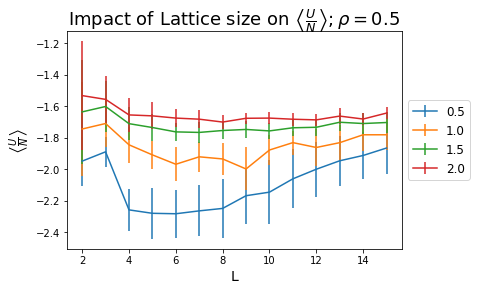

The potential energy starts to converge at L >= 6, for the 4 different temperatures the simulation was performed.


In [0]:
#Plot the impact of L on potential energy
for i,t in enumerate(Temps):
    Uexp = []
    for N in L:
        a = (results[N][i,0])
        s = (results[N][i,1])
        Uexp.append((a,s))
    Uexp = numpy.array(Uexp)
    plt.errorbar(L,Uexp[:,0],Uexp[:,1])
plt.xlabel(r'L',fontsize=14)
plt.ylabel(r'$\left<\frac{U}{N}\right>$',fontsize=14)
plt.title(r'Impact of Lattice size on $\left<\frac{U}{N}\right>; \rho = 0.5$',fontsize=18)
plt.legend(Temps,loc='center left', bbox_to_anchor=(1, 0.5),fontsize=12)
plt.show()
print('The potential energy starts to converge at L >= 6, for the 4 different temperatures the simulation was performed.')

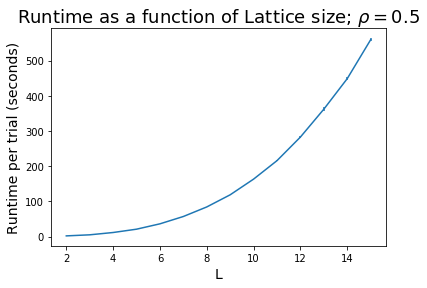

L = 6 seems to have a decent run time. It is not too big.


In [0]:
#Estimate run time as a function of size
times = []
for N in L:
    times.append((numpy.average(results[N][:,2]),numpy.std(results[N][:,2])))
times = numpy.array(times)
plt.errorbar(L,times[:,0],times[:,1])
plt.xlabel(r'L',fontsize=14)
plt.ylabel(r'Runtime (seconds)',fontsize=14)
plt.title(r'Runtime as a function of Lattice size; $\rho = 0.5$',fontsize=18)
plt.show()
print('L = 6 seems to have a decent run time. It is not too big.')

In [0]:
###Trial tests to probe the influence of occupied site density on <U>
L = 6
Temps = numpy.arange(0.5,2.1,0.5)
Sizes = range(20,L*L*L,20)
results = {}
for N in Sizes:
    print(N)
    onerun = []
    for T in Temps:
        print("\t",T)
        occupied, lattice = init(N,L) # N, L
        start = time.time()
        U = run(5e3,T,occupied, lattice)
        finish = time.time()
        a, s = analyze(U)
        onerun.append((a,s,finish-start))
    results[N] =  numpy.array(onerun)

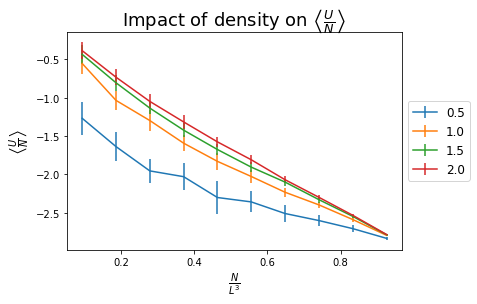

The plot is linear, i.e. there is no plateau region. As such, the average potential energy 
doesn't converge with density.


In [0]:
#Plot the impact of density on potential energy
density = numpy.array(Sizes)/(L*L*L)
for i,t in enumerate(Temps):
    Uexp = []
    for N in Sizes:
        a = (results[N][i,0])
        s = (results[N][i,1])
        Uexp.append((a,s))
    Uexp = numpy.array(Uexp)
    plt.errorbar(density,Uexp[:,0],Uexp[:,1])

plt.xlabel(r'$\frac{N}{L^3}$',fontsize=14)
plt.ylabel(r'$\left<\frac{U}{N}\right>$',fontsize=14)
plt.title(r'Impact of density on $\left<\frac{U}{N}\right>$',fontsize=18)
plt.legend(Temps,loc='center left', bbox_to_anchor=(1, 0.5),fontsize=12)
plt.show()
print("The plot is linear, i.e. there is no plateau region. As such, the average potential energy \ndoesn't converge with density.")
# This plot makes sense

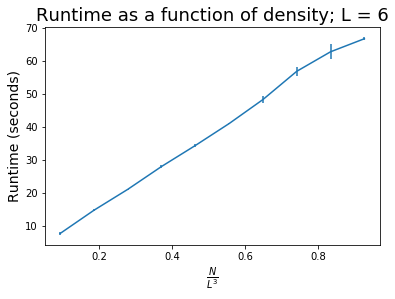

Since the runtime scales linearly (as expected), density = 0.5 seems to be a decent choice


In [0]:
#Estimate run time as a function of density
density = numpy.array(Sizes)/(L*L*L)
times = []
for N in Sizes:
    times.append((numpy.average(results[N][:,2]),numpy.std(results[N][:,2])))
times = numpy.array(times)
plt.errorbar(density,times[:,0],times[:,1])
plt.xlabel(r'$\frac{N}{L^3}$',fontsize=14)
plt.ylabel(r'Runtime (seconds)',fontsize=14)
plt.title(r'Runtime as a function of density; L = 6',fontsize=18)
plt.show()
print('Since the runtime scales linearly (as expected), density = 0.5 seems to be a decent choice')

In [0]:
###Trial tests to probe the system behavior as a function of Temperature
L = 6
Temps = numpy.arange(0.1,2.1,0.1)
Sizes = [20, 40, 80, 108, 140, 200]
results = {}
for N in Sizes:
    print(N)
    onerun = []
    for T in Temps:
        print("\t",T)
        occupied, lattice = init(N,L) # N, L
        U = run(5e3,T,occupied, lattice)
        a, s = analyze(U)
        onerun.append((a,s))
    results[N] =  numpy.array(onerun)

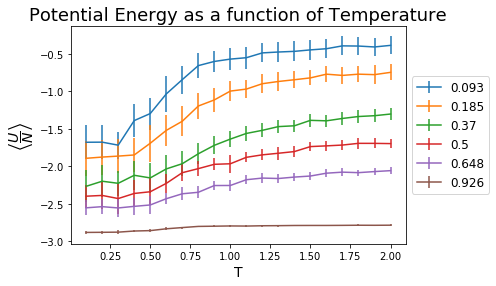

Based on the behavior, ideal 3 Temperature choices will be T = 0.2, T = 0.6 and T = 1.4


In [0]:
#Plot U as a function of T for different densities
plt.errorbar(Temps,results[20][:,0],results[20][:,1])
plt.errorbar(Temps,results[40][:,0],results[40][:,1])
plt.errorbar(Temps,results[80][:,0],results[80][:,1])
plt.errorbar(Temps,results[108][:,0],results[108][:,1])
plt.errorbar(Temps,results[140][:,0],results[140][:,1])
plt.errorbar(Temps,results[200][:,0],results[200][:,1])
density = numpy.array([20, 40, 80, 108, 140, 200])/(6*6*6)
density = numpy.around(density,decimals=3)
plt.legend(density,loc='center left', bbox_to_anchor=(1, 0.5),fontsize=12)
plt.xlabel("T", fontsize=14)
plt.ylabel(r"$\left<\dfrac{U}{N}\right>$",fontsize=14)
plt.title(r'Potential Energy as a function of Temperature',fontsize=18)
plt.show()
print('Based on the behavior, ideal 3 Temperature choices will be T = 0.2, T = 0.6 and T = 1.4')

0.2 	 runtime =  380.84  sec
0.6 	 runtime =  380.13  sec
1.0 	 runtime =  375.77  sec
1.4 	 runtime =  376.26  sec


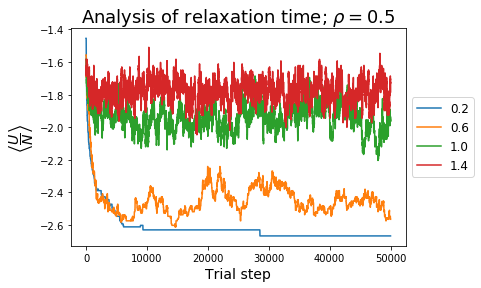

In [0]:
###Analyze the relaxation time at different temperatures
#density = 0.5
L = 6
T = numpy.arange(0.2,1.5,0.4)
for temps in T:
    occupied, lattice = init((L*L*L)//2,L) # N, L
    start = time.time()
    U = run(5e4,temps,occupied, lattice)
    stop = time.time()
    print(numpy.around(temps,decimals=2),'\t runtime = ',numpy.around(stop-start,decimals=2),' sec')
    plt.plot(U)
plt.xlabel('Trial step',fontsize=14)
plt.ylabel(r"$\left<\dfrac{U}{N}\right>$",fontsize=14)
plt.title(r'Analysis of relaxation time; $\rho = 0.5$',fontsize=18)
plt.legend(numpy.around(T,decimals=2),loc='center left', bbox_to_anchor=(1, 0.5),fontsize=12)
plt.show()

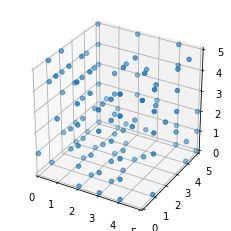

In [0]:
###Just a trial to view occupied sites in 3D
L = 6
N = L*L*L//2
occupied,lattice = init(N,L)
fig = plt.figure()
ax = plt.axes(projection='3d')
occ = [];
for site in occupied:
    z,x,y = siteto3D(site,L)
    occ.append((x,y,z))
occ = numpy.array(occ)
ax.scatter3D(occ[:,0],occ[:,1],occ[:,2])
ax.set_xlim3d(0, L-1)
ax.set_ylim3d(0, L-1)
ax.set_zlim3d(0, L-1)
ax.set_aspect("equal")
plt.show()

In [0]:
print('Based on initial parameter analysis, following values should be reasonable:')
print('\t density = 0.5')
print('\t L = 6')
print('\t T = [0.2, 0.6, 1.4]')
print('\t nsteps for trial moves = 30,000')

Based on initial parameter analysis, following values should be reasonable:
	 density = 0.5
	 L = 6
	 T = [0.2, 0.6, 1.4]
	 nsteps for trial moves = 30,000
